In [1]:
from tropycal import realtime

# DataSource: UCAR
This datasource

In [2]:
realtime_obj = realtime.Realtime(jtwc=True, jtwc_source='ucar')

--> Starting to read in current storm data
--> Completed reading in current storm data (162.7 seconds)


In [3]:
active_storms = realtime_obj.list_active_storms()
active_storms

['AL132023', 'AL142023', 'EP112023', 'WP122023']

<GeoAxes: title={'left': 'Summary & NHC 7-Day Formation Outlook', 'right': 'Valid: 06 UTC 08 Sep 2023'}>

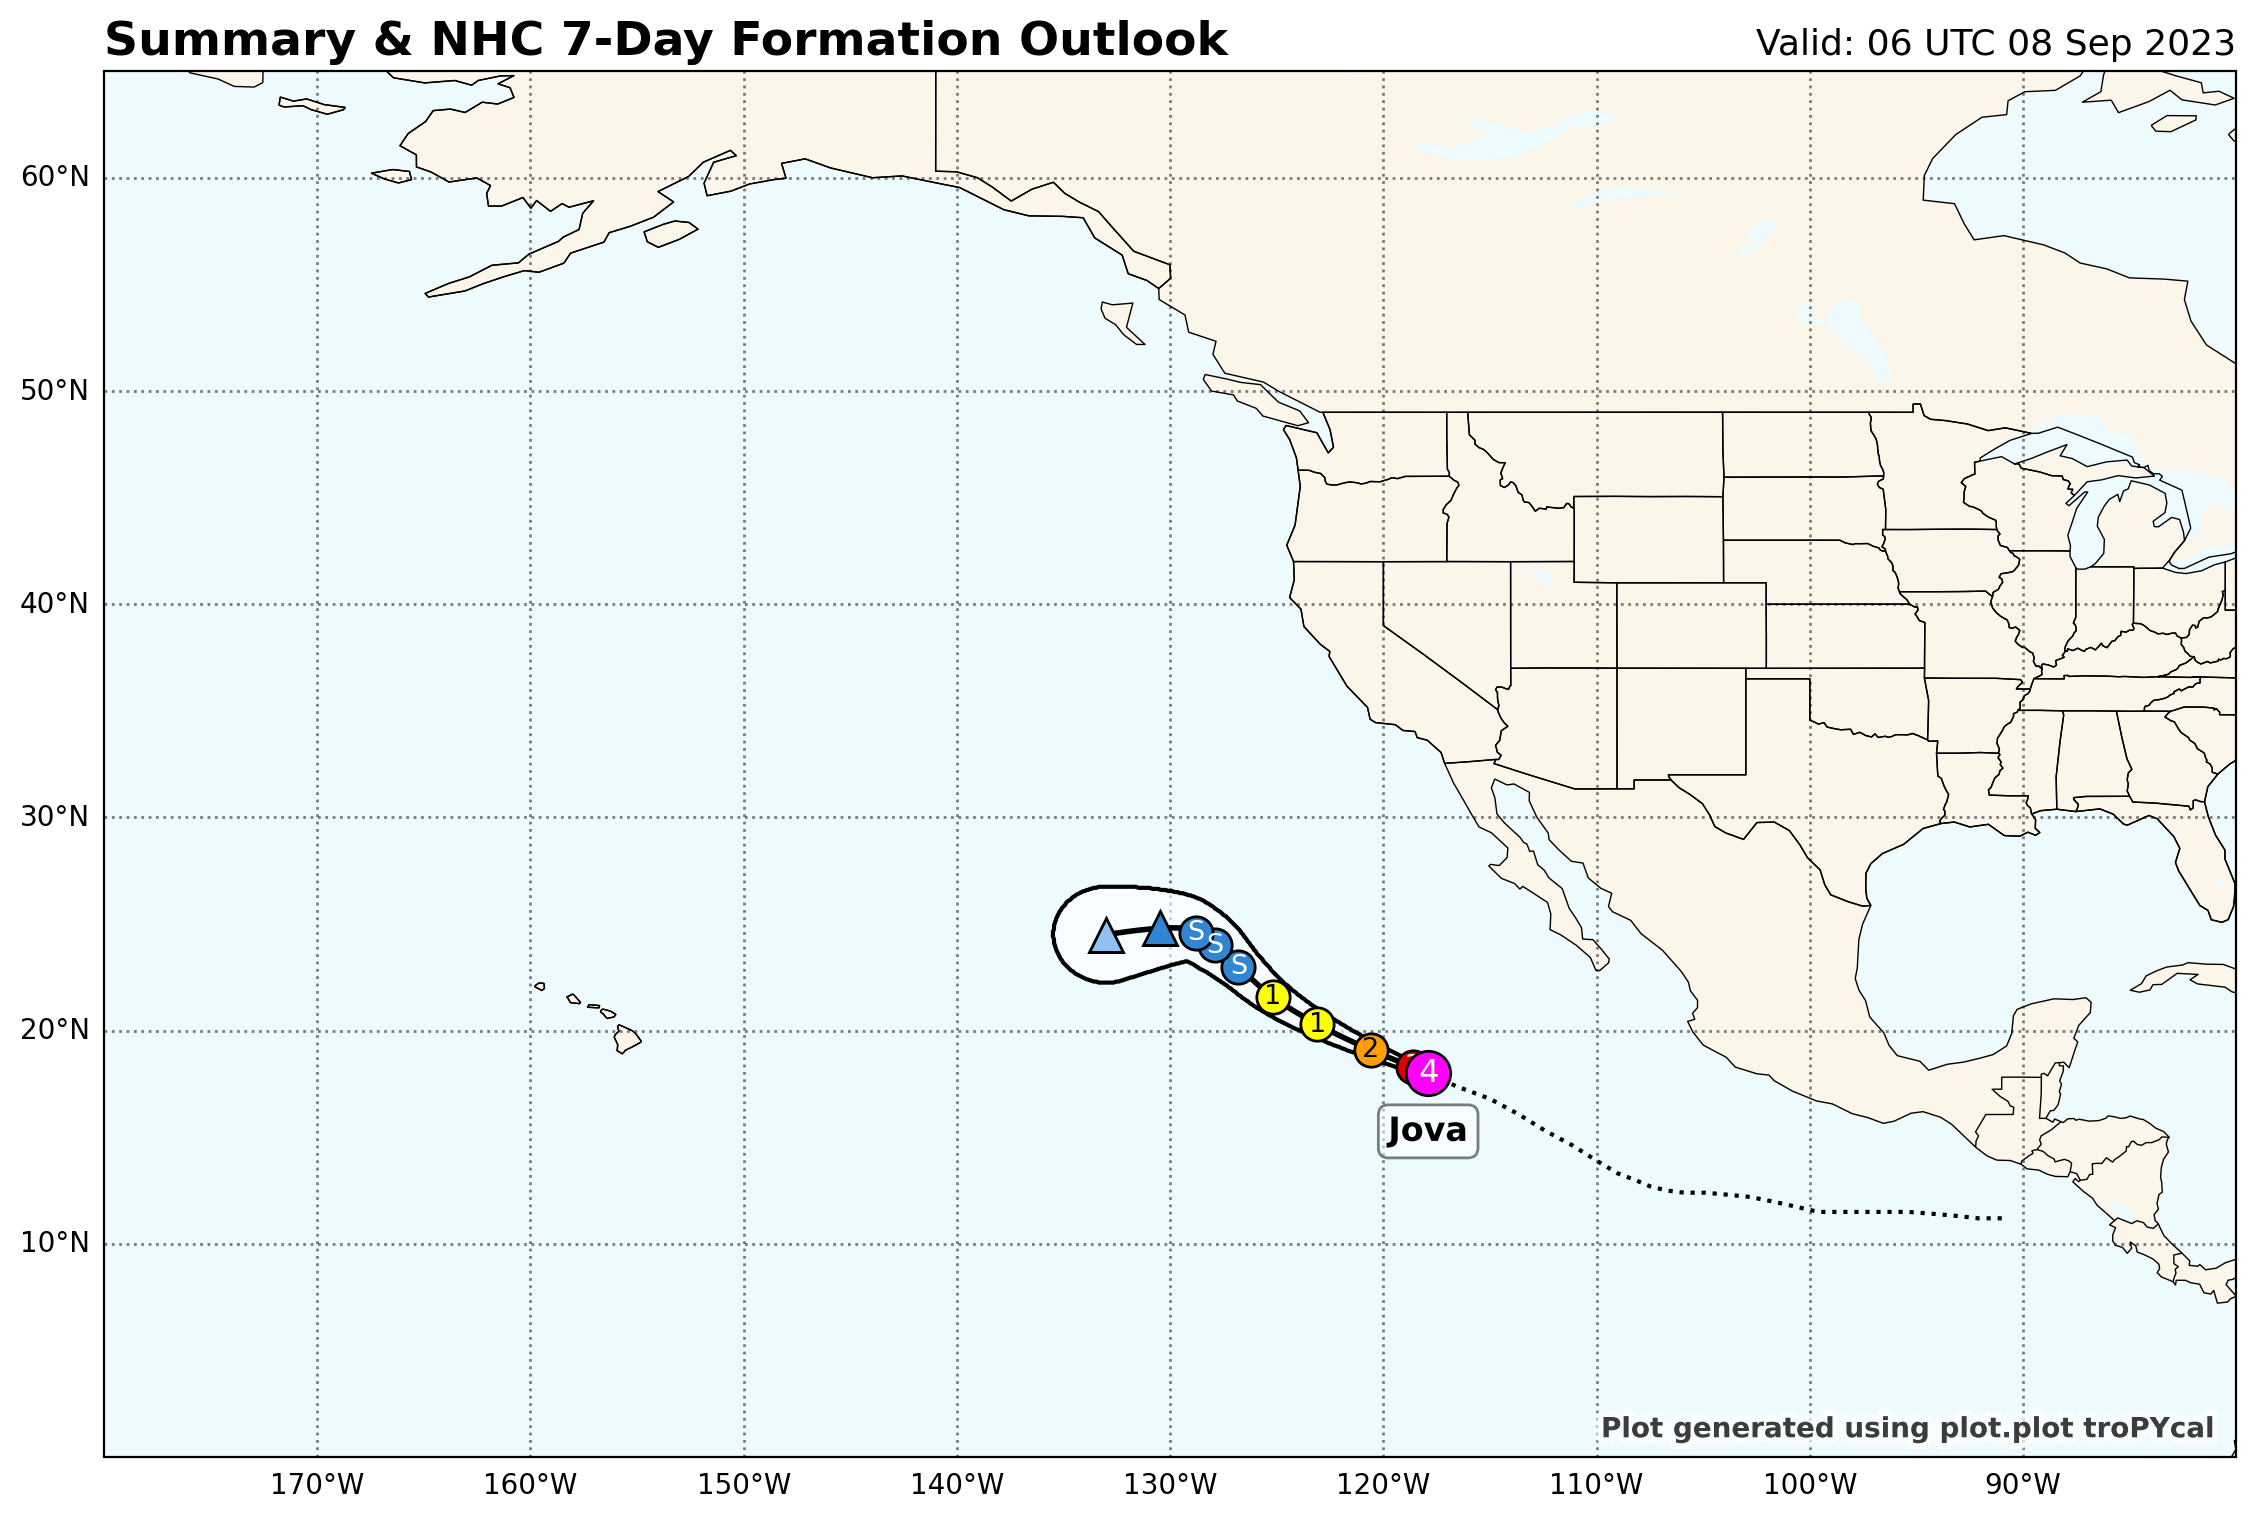

In [4]:
realtime_obj.plot_summary(domain='east_pacific')

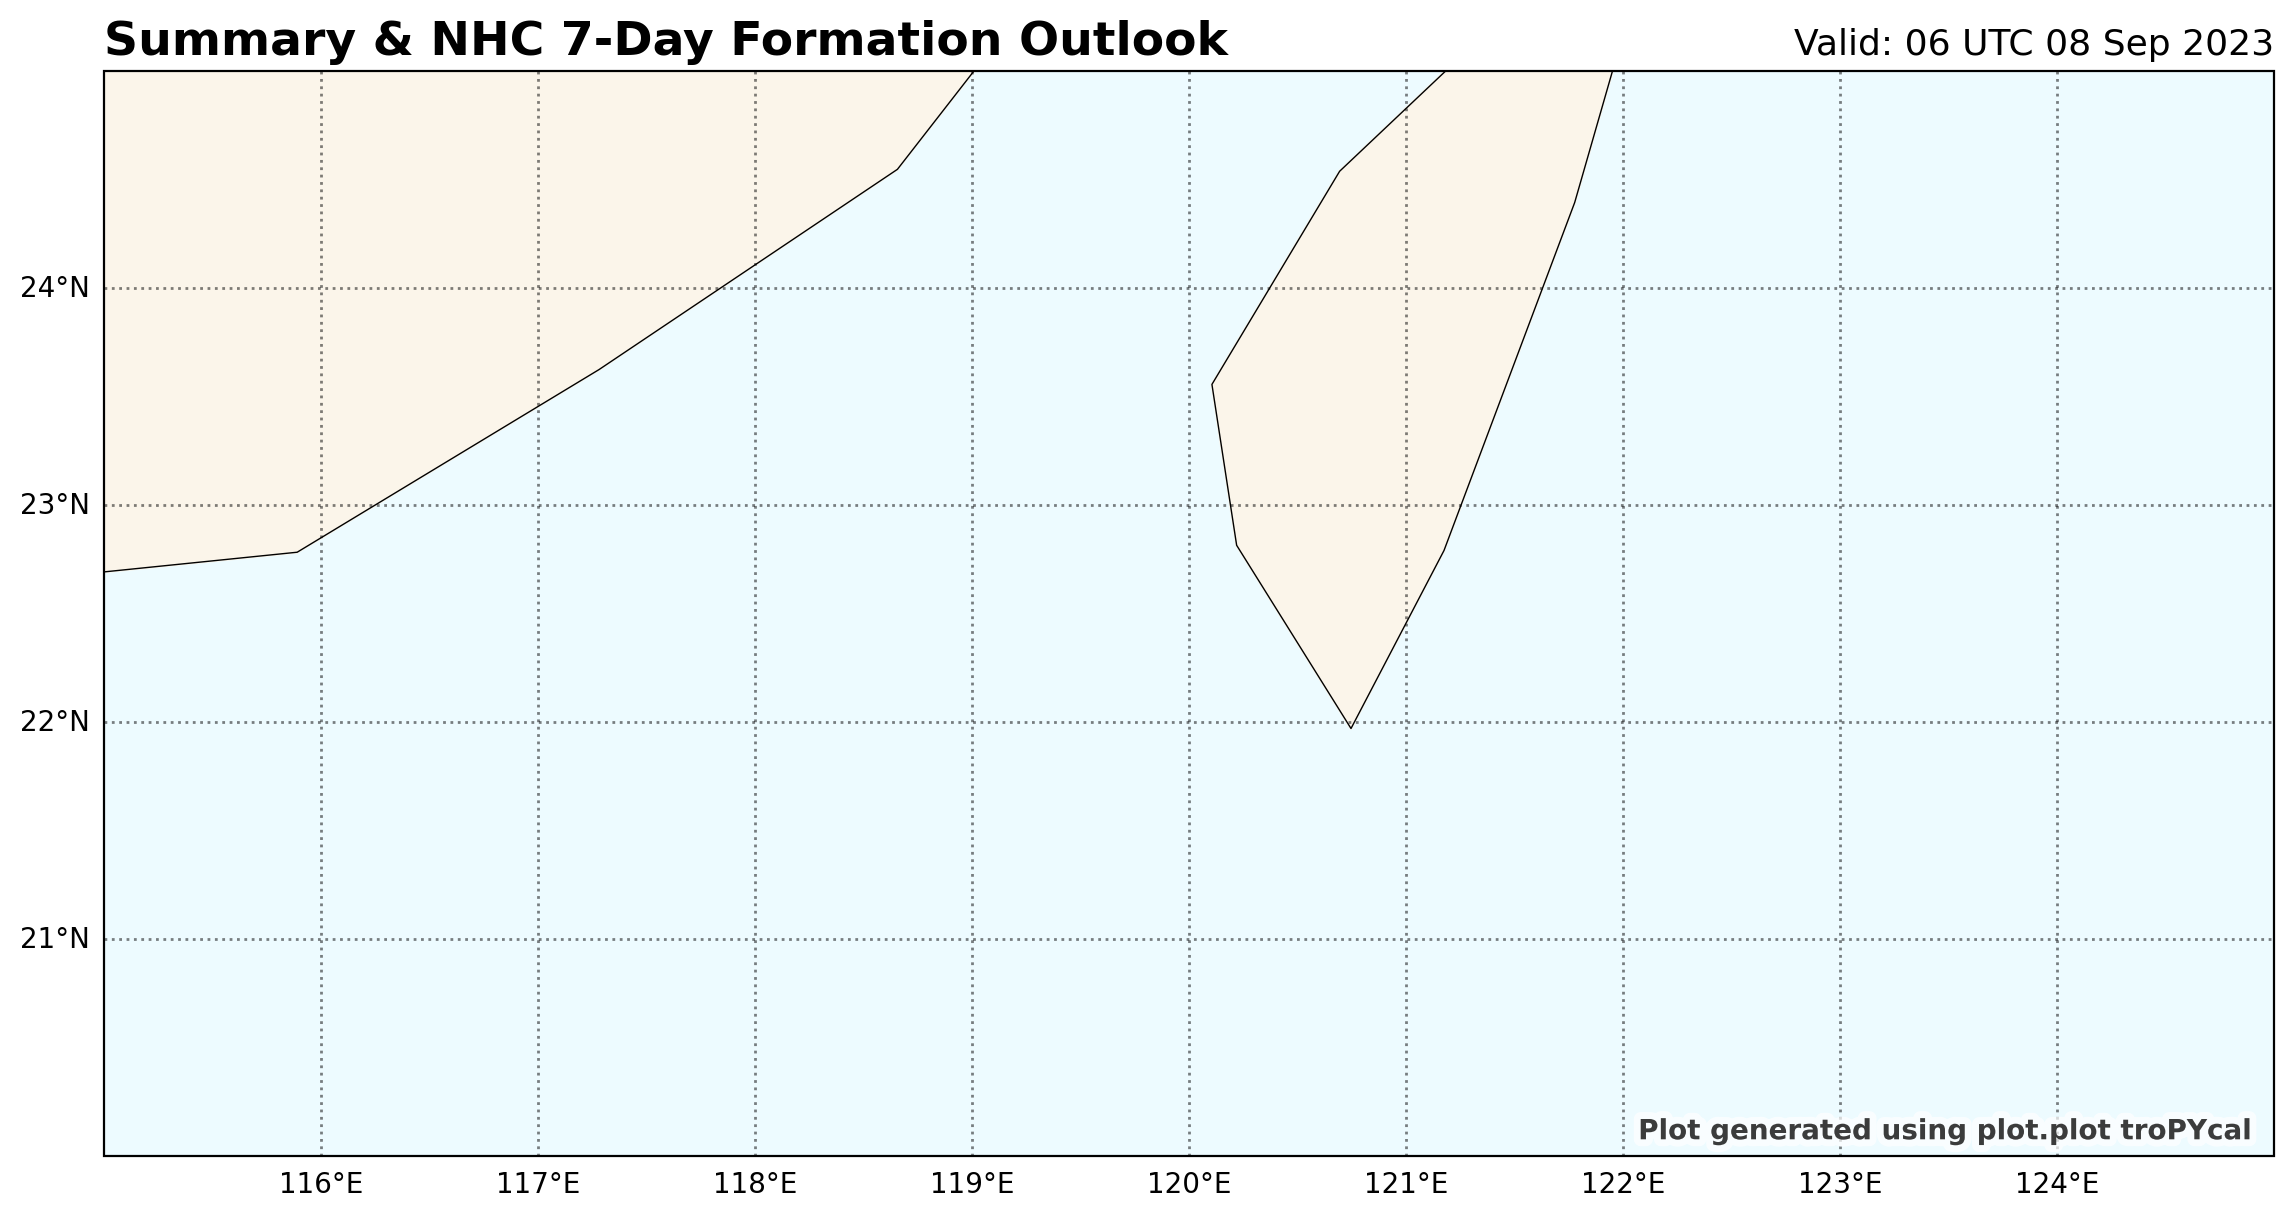

In [5]:
tw_domain = {'w':115,'e':125,'s':20,'n':25}
p = realtime_obj.plot_summary(domain=tw_domain)

In [6]:
storm = realtime_obj.get_storm(active_storms[2])

In [9]:
forecasts = storm.get_operational_forecasts()


In [23]:
storm_forecast = storm.get_forecast_realtime(ssl_certificate=False)

In [67]:
forecasts['HWRF'].keys()

dict_keys(['2023090318', '2023090400', '2023090406', '2023090412', '2023090418', '2023090500', '2023090506', '2023090512', '2023090518', '2023090600', '2023090606', '2023090612', '2023090618', '2023090700', '2023090706', '2023090712', '2023090718'])

In [47]:
my_models = models_dict = {
    #"GFSO": "Global Forecast System Operational",
    "HWRF": "Hurricane Weather Research and Forecasting Model",
    "UKX": "UK Met Office Model",
    #"NAM": "North American Mesoscale Forecast System",
    "CMC": "Canadian Meteorological Centre",
    "HMON": "Hurricanes in a Multi-scale Ocean-coupled Non-hydrostatic Model",
    "ICON": "Icosahedral Nonhydrostatic Model"
}

for model in my_models.keys():
    forecasts[model][max(forecasts[model].keys())]

In [40]:
lats = storm['lat'].tolist() + storm_forecast['lat']
lons = storm['lon'].tolist() + storm_forecast['lon']

storm_s = min(lats) - 5
storm_n = max(lats) + 5
storm_w = max(lons) + 5
storm_e = min(lons) - 5
storm_box = (storm_w, storm_e, storm_s, storm_n)
storm_box

(-86.0, -138.0, 6.199999999999999, 29.8)

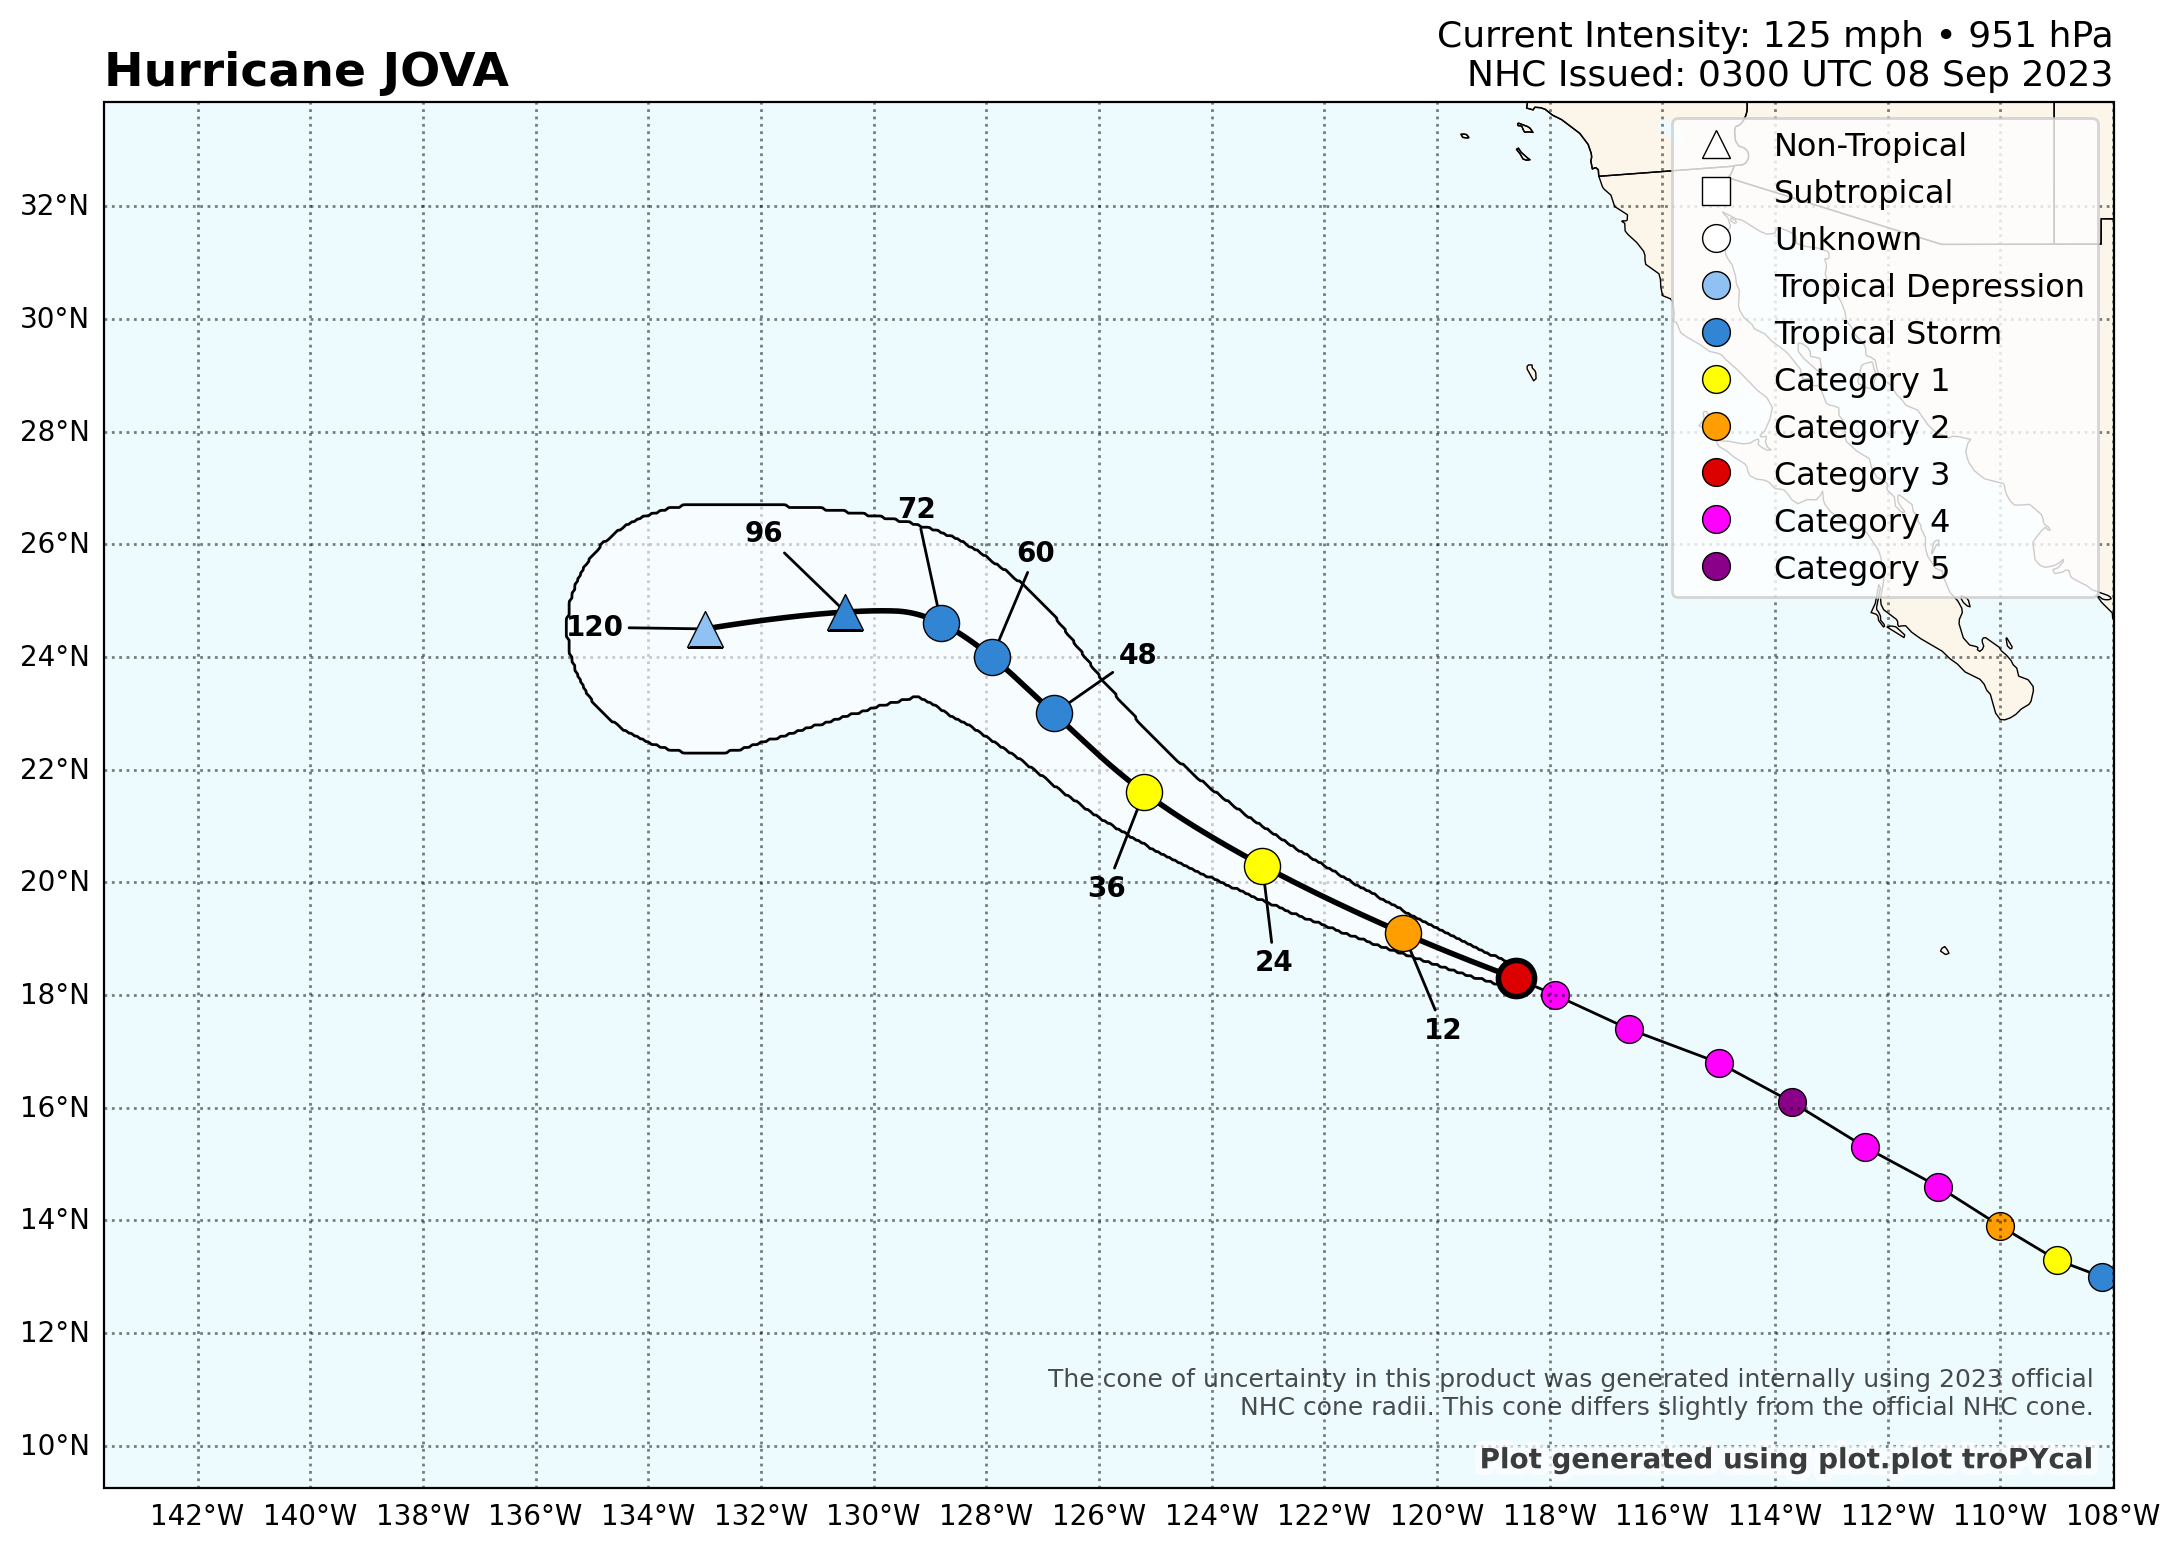

In [41]:
a = storm.plot_forecast_realtime(ssl_certificate=False, prop={'ms':10, 'cone_lw':2})

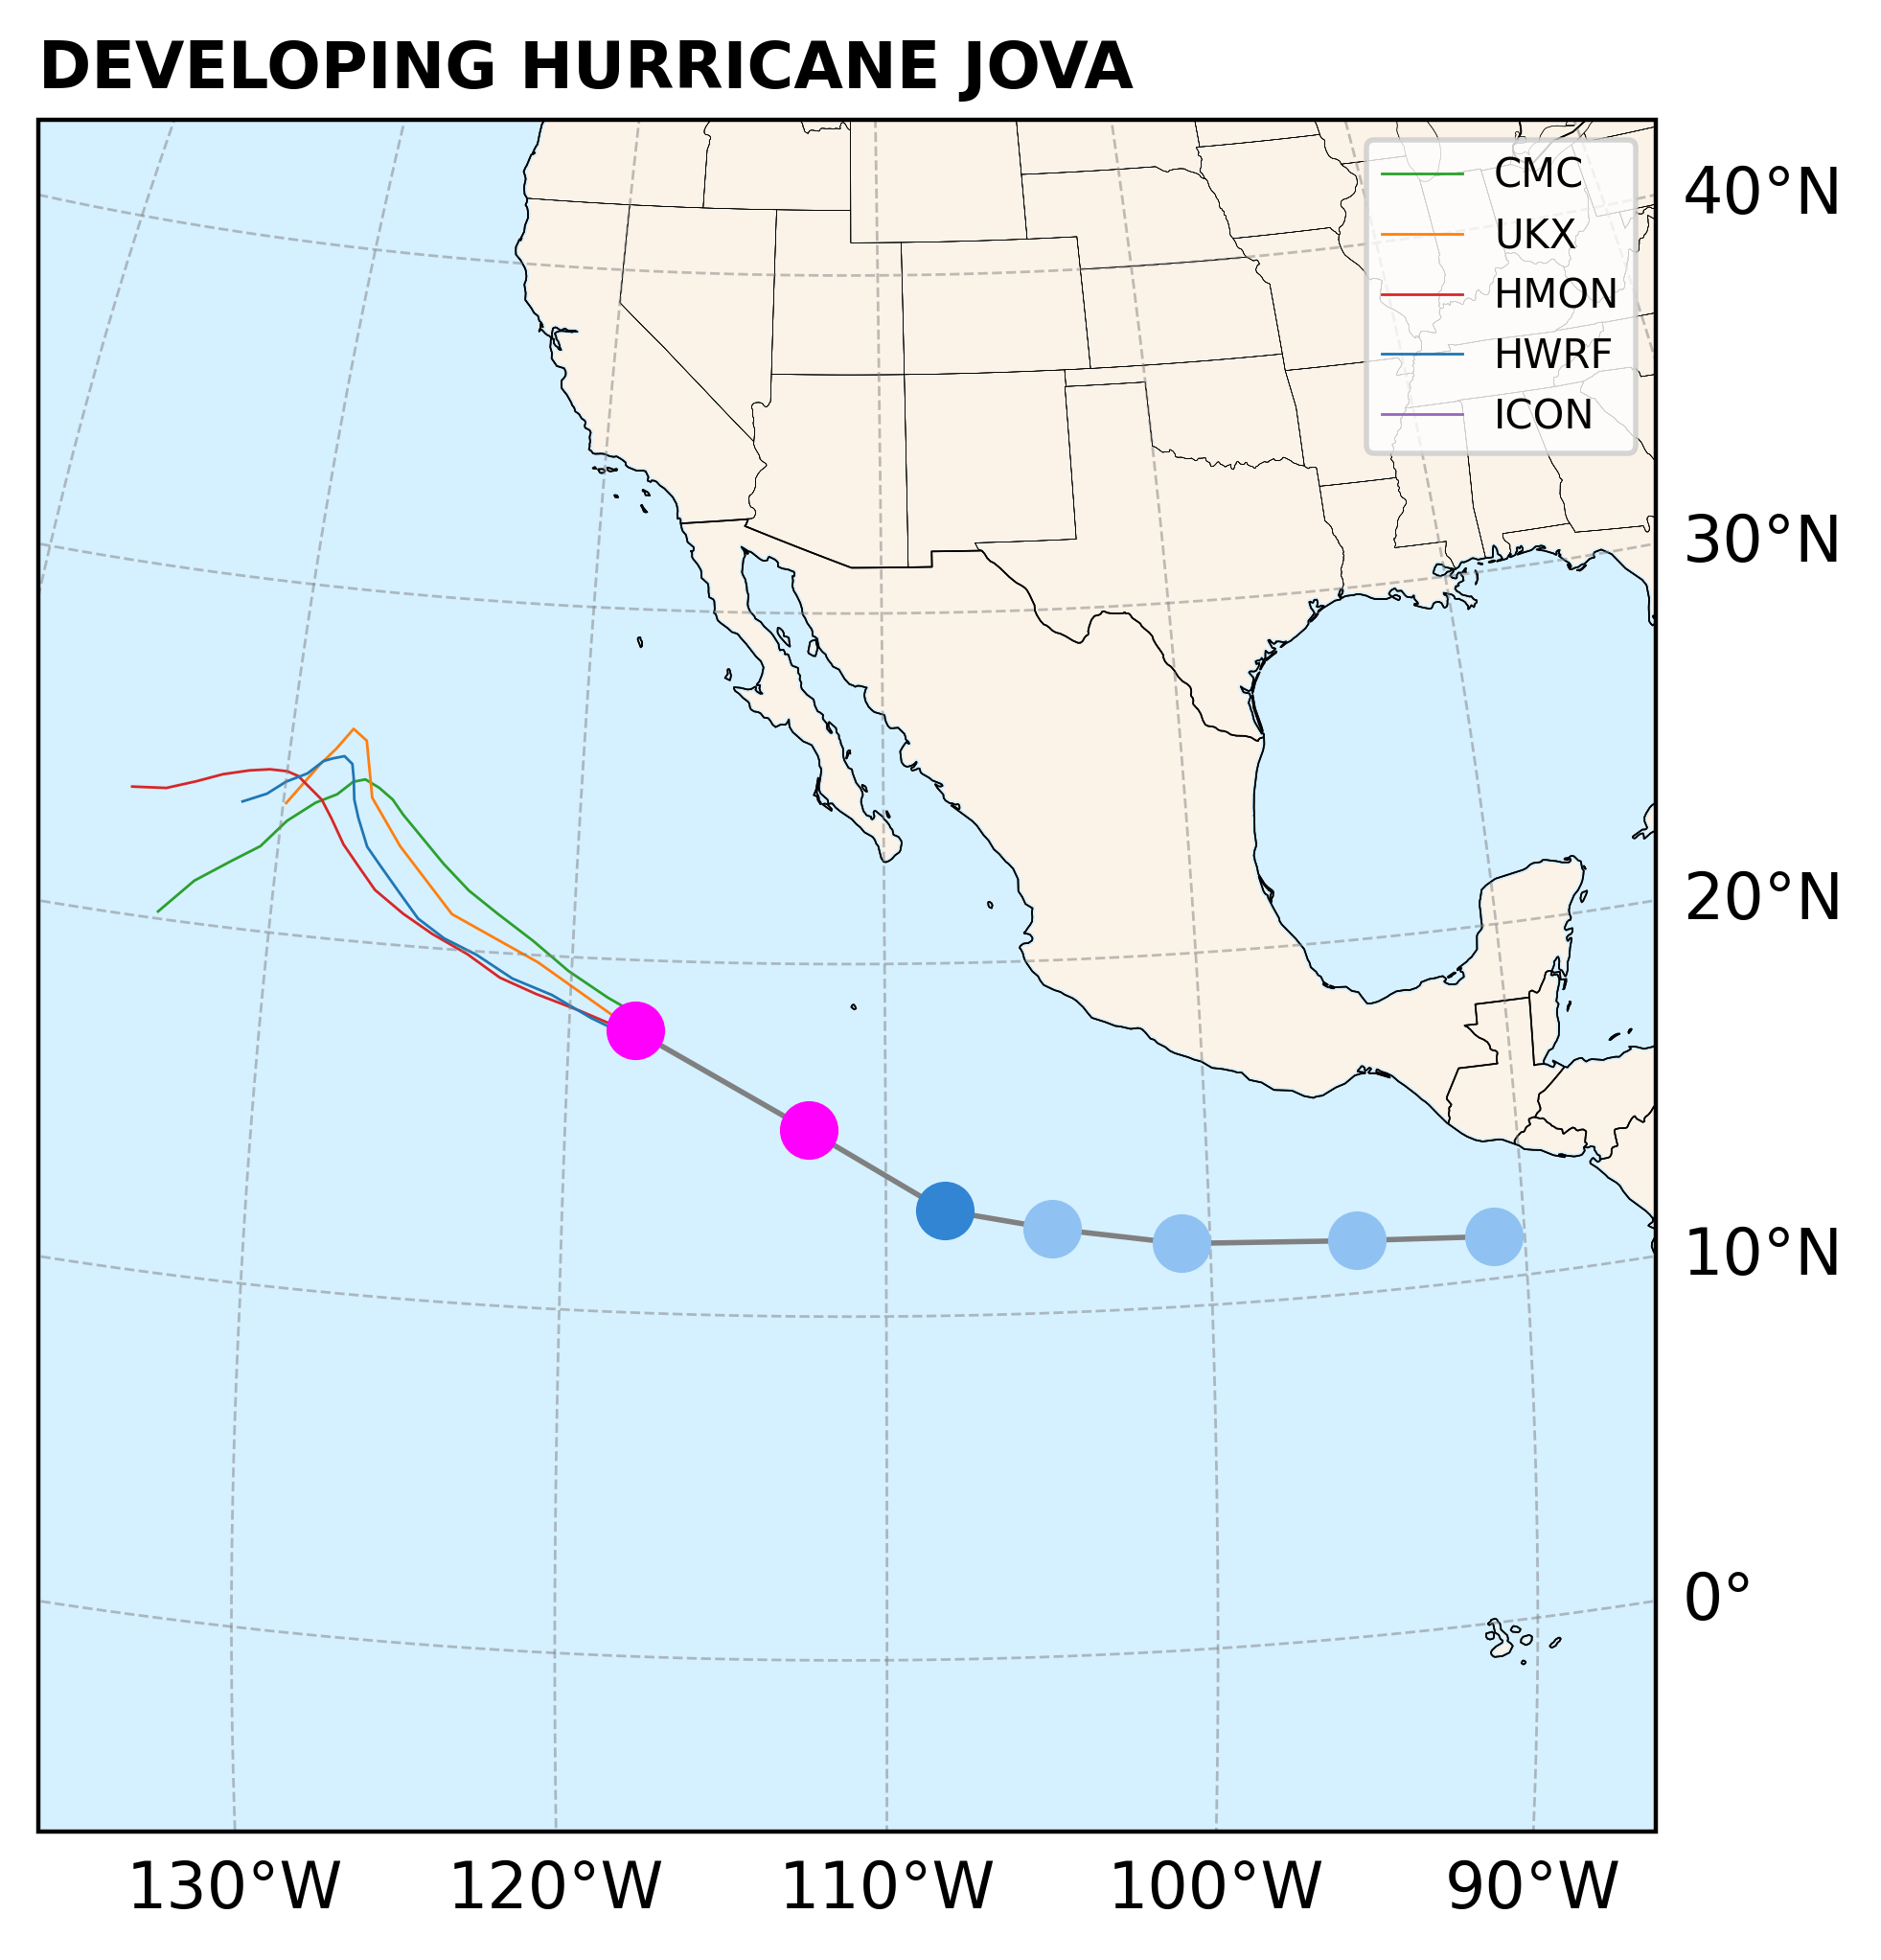

In [77]:
import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from cartopy.mpl.ticker import LatitudeFormatter, LatitudeLocator, LongitudeFormatter
from matplotlib.pyplot import Axes
from tropycal.realtime import RealtimeStorm


def get_colors_sshws(wind_speed: int) -> str:
    r"""
    Retrieve the default colors for the Saffir-Simpson Hurricane Wind Scale (SSHWS).

    Parameters
    ----------
    wind_speed : int or list
        Sustained wind speed in knots.

    Returns
    -------
    str
        Hex string for the corresponding color.
    """

    # # If category string passed, convert to wind
    # if isinstance(wind_speed, str):
    #     wind_speed = category_label_to_wind(wind_speed)

    # Return default SSHWS category color scale
    if wind_speed < 5:
        return "#FFFFFF"
    elif wind_speed < 34:
        return "#8FC2F2"  # '#7DB7ED'
    elif wind_speed < 64:
        return "#3185D3"
    elif wind_speed < 83:
        return "#FFFF00"
    elif wind_speed < 96:
        return "#FF9E00"
    elif wind_speed < 113:
        return "#DD0000"
    elif wind_speed < 137:
        return "#FF00FC"
    else:
        return "#8B0088"


def get_plot_box(
    lats: list[float], lons: list[float]
) -> tuple[tuple[float, float, float, float], float, float]:
    storm_s = min(lats)
    storm_n = max(lats)
    storm_w = max(lons)
    storm_e = min(lons)
    # storm_box = (storm_w, storm_e, storm_s, storm_n)
    storm_width = abs(storm_e - storm_w)
    storm_height = abs(storm_s - storm_n)

    central_lon = (storm_w + storm_e) / 2
    central_lat = (storm_n + storm_s) / 2

    padding_vertical = storm_height / 4
    padding_horizontal = storm_width / 4

    # If same then it is a box
    plot_height = max(
        [storm_height + padding_vertical, storm_width + padding_horizontal]
    )
    plot_width = max(
        [storm_height + padding_vertical, storm_width + padding_horizontal]
    )

    plot_n = central_lat + plot_height / 2
    plot_s = central_lat - plot_height / 2
    plot_e = central_lon + plot_width / 2
    plot_w = central_lon - plot_width / 2
    plot_box = (plot_w, plot_e, plot_s, plot_n)
    return plot_box, central_lat, central_lon


def add_annotation_pointers(ax: Axes, fhr: float, xy: tuple[float, float]) -> None:
    ax.annotate(
        text=str(fhr),
        xy=xy,
        xycoords="data",
        xytext=(20, 20),
        textcoords="offset points",
        fontweight="bold",
        ha="center",
        va="center",
        arrowprops=dict(
            arrowstyle="-",
            shrinkA=0,
            shrinkB=0,
            connectionstyle="arc3",
            color="k",
        ),
        transform=ccrs.PlateCarree(),
        clip_on=True,
        zorder=1,
    )


def add_background_maps(ax: Axes) -> None:
    # Plot coastlines and political boundaries
    ax.add_feature(
        cfeature.STATES.with_scale("50m"),
        linewidths=0.1,
        linestyle="solid",
        edgecolor="k",
    )
    ax.add_feature(
        cfeature.BORDERS.with_scale("50m"),
        linewidths=0.3,
        linestyle="solid",
        edgecolor="k",
    )
    ax.add_feature(
        cfeature.COASTLINE.with_scale("50m"),
        linewidths=0.3,
        linestyle="solid",
        edgecolor="k",
    )

    # Fill in continents in light gray
    ax.add_feature(
        cfeature.LAND.with_scale("50m"), facecolor=land_color, edgecolor="face"
    )
    ax.add_feature(
        cfeature.OCEAN.with_scale("50m"), facecolor=water_color, edgecolor="face"
    )


def add_grid_lines(ax: Axes) -> None:
    axes_label_style = {"size": 12, "color": "black"}
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5,
        color="gray",
        alpha=0.5,
        linestyle="--",
    )
    gl.top_labels = False
    gl.left_labels = False
    gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.ylabel_style = axes_label_style
    gl.xlabel_style = axes_label_style


def plot_storm(storm: RealtimeStorm, storm_forecast: dict) -> plt.figure:
    by_hour = 12
    storm["should_plot_step"] = [x.hour / by_hour == 0 for x in storm["time"]]
    storm_forecast["already_forcasted"] = [
        (datetime.timedelta(hours=x) + storm_forecast["init"]) <= storm.time.max()
        for x in storm_forecast["fhr"]
    ]

    fig, ax = plot_base(storm, storm_forecast)

    ax.set_title(
        "DEVELOPING HURRICANE " + storm["name"],
        loc="left",
        # fontsize=25,
        fontweight="bold",
    )
    ax.legend(handles=[td, ts, c1, c2, c3, c4, c5], prop={"size": 7.5})

    # Plot historical (already happened) Dots
    storm_line_x = []
    storm_line_y = []
    for i in range(0, len(storm["lat"])):
        if not storm["should_plot_step"][i]:
            continue
        ax.plot(
            storm["lon"][i],
            storm["lat"][i],
            transform=ccrs.PlateCarree(),
            linewidth=2,
            marker="o",
            markersize=marker_size,
            color=get_colors_sshws(np.nan_to_num(storm["vmax"][i])),
            zorder=2,
        )
        storm_line_x.append(storm["lon"][i])
        storm_line_y.append(storm["lat"][i])

    # Plot Already happened Line
    ax.plot(
        storm_line_x,
        storm_line_y,
        transform=ccrs.PlateCarree(),
        linewidth=1,
        color="gray",
        zorder=1,
    )

    # Forecast Dots
    for i in range(0, len(storm_forecast["lat"])):
        if storm_forecast["already_forcasted"][i]:
            continue

        fhr = storm_forecast["fhr"][i]
        x = storm_forecast["lon"][i]
        y = storm_forecast["lat"][i]

        ax.plot(
            x,
            y,
            transform=ccrs.PlateCarree(),
            marker="o",
            color=get_colors_sshws(np.nan_to_num(storm_forecast["vmax"][i])),
            markersize=marker_size,
            zorder=2,
        )
        # Lables for hrs after forecast
        if not fhr % 24 == 0:
            continue
        add_annotation_pointers(ax, fhr=fhr, xy=(x, y))

    return fig


def plot_base(storm: RealtimeStorm, storm_forecast: dict) -> tuple[plt.figure, Axes]:
    lats = storm["lat"].tolist() + storm_forecast["lat"]
    lons = storm["lon"].tolist() + storm_forecast["lon"]

    plot_box, central_lat, central_lon = get_plot_box(lats, lons)

    fig = plt.figure(figsize=(5, 5), dpi=400)

    ax = plt.axes(
        projection=ccrs.Orthographic(
            central_longitude=central_lon, central_latitude=central_lat
        )
    )

    add_background_maps(ax)

    add_grid_lines(ax)
    ax.set_extent(plot_box, crs=ccrs.PlateCarree())
    fig.tight_layout()
    ax.set_aspect("auto")

    add_background_maps(ax)

    return fig, ax


def plot_all_forecasts(storm: RealtimeStorm, forecasts: dict) -> plt.figure:
    fig, ax = plot_base(storm, forecasts["HWRF"][max(forecasts["HWRF"].keys())])

    ax.set_title(
        "DEVELOPING HURRICANE " + storm["name"],
        loc="left",
        # fontsize=25,
        fontweight="bold",
    )

    # Plot historical (already happened) Dots
    storm_line_x = []
    storm_line_y = []
    for i in range(0, len(storm["lat"])):
        if not storm["should_plot_step"][i]:
            continue
        ax.plot(
            storm["lon"][i],
            storm["lat"][i],
            transform=ccrs.PlateCarree(),
            linewidth=2,
            marker="o",
            markersize=marker_size,
            color=get_colors_sshws(np.nan_to_num(storm["vmax"][i])),
            zorder=2,
        )
        storm_line_x.append(storm["lon"][i])
        storm_line_y.append(storm["lat"][i])

    # Plot Already happened Line
    ax.plot(
        storm_line_x,
        storm_line_y,
        transform=ccrs.PlateCarree(),
        linewidth=1,
        color="gray",
        zorder=1,
    )

    # Forecast Lines
    for model in forecasts.keys():
        if not(model in my_models.keys()):
            continue
        storm_forecast = forecasts[model][max(forecasts[model].keys())]
        by_hour = 12
        storm["should_plot_step"] = [x.hour / by_hour == 0 for x in storm["time"]]
        storm_forecast["already_forcasted"] = [
            (datetime.timedelta(hours=x) + storm_forecast["init"]) < storm.time.max()
            for x in storm_forecast["fhr"]
        ]

        plot_x = []
        plot_y = []
        for i in range(0, len(storm_forecast["lat"])):
            if storm_forecast["already_forcasted"][i]:
                continue
            else:
                plot_x.append(storm_forecast["lon"][i])
                plot_y.append(storm_forecast["lat"][i])

        ax.plot(
            plot_x,
            plot_y,
            transform=ccrs.PlateCarree(),
            linewidth=0.5,
            color=my_models[model][
                "color"
            ],  # use the color from the dictionary, default to black if not found
            zorder=1,
            label=model,
        )
    ax.legend(loc="upper right", prop={"size": 7.5})
    return fig


cone_color = "#fffde6"
cone_color = "#e6f2ff"
cone_color = "#fff8d5"
water_color = "#d5f0ff"
land_color = "#fcf3e8"
land_scale = "50m"
marker_size = 10


legend_size = 7

ex = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Non-Tropical",
    marker="^",
    color="w",
)
sb = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Subtropical",
    marker="s",
    color="w",
)
uk = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Unknown",
    marker="o",
    color="w",
)
td = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Tropical Depression",
    marker="o",
    color=get_colors_sshws(33),
)
ts = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Tropical Storm",
    marker="o",
    color=get_colors_sshws(34),
)
c1 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 1",
    marker="o",
    color=get_colors_sshws(64),
)
c2 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 2",
    marker="o",
    color=get_colors_sshws(83),
)
c3 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 3",
    marker="o",
    color=get_colors_sshws(96),
)
c4 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 4",
    marker="o",
    color=get_colors_sshws(113),
)
c5 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 5",
    marker="o",
    color=get_colors_sshws(137),
)

my_cone = {
    0: 0,
    12: 16,
    24: 26,
    36: 39,
    48: 53,
    60: 67,
    72: 81,
    96: 99,
    108: 145,
    120: 205,
}

my_models = {
    "HWRF": {
        "name": "Hurricane Weather Research and Forecasting Model",
        "color": "#1f77b4",  # muted blue
    },
    "UKX": {"name": "UK Met Office Model", "color": "#ff7f0e"},  # safety orange
    "CMC": {
        "name": "Canadian Meteorological Centre",
        "color": "#2ca02c",  # cooked asparagus green
    },
    "HMON": {
        "name": "Hurricanes in a Multi-scale Ocean-coupled Non-hydrostatic Model",
        "color": "#d62728",  # brick red
    },
    "ICON": {
        "name": "Icosahedral Nonhydrostatic Model",
        "color": "#9467bd",  # muted purple
    },
}

# fig = plot_storm(storm, storm_forecast)
# fig.show()

fig = plot_all_forecasts(storm, forecasts)
fig.show()


In [43]:
fig.savefig(f"TEST_myimage.jpg")

In [ ]:



# Put a background image on for nice sea rendering.
# ax.stock_img()
from matplotlib.offsetbox import AnchoredText
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
def main():
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1,projection=ccrs.Orthographic(central_latitude=-8, central_longitude=125))
    ax1.set_extent([80, 170, -45, 30], crs=ccrs.PlateCarree())
    #ax = plt.axes(projection=ccrs.Orthographic())
    ax2 = fig.add_subplot(2, 2, 2,projection=ccrs.PlateCarree())
    ax2.set_extent([80, 170, -45, 30], crs=ccrs.PlateCarree())


    # Put a background image on for nice sea rendering.
    ax1.stock_img()
    ax2.stock_img()


    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'

    ax1.add_feature(cfeature.LAND)
    ax1.add_feature(cfeature.COASTLINE)
    ax1.add_feature(states_provinces, edgecolor='gray')

    # Add a text annotation for the license information to the
    # the bottom right corner.
    text = AnchoredText('\u00A9 {}; license: {}'
                        ''.format(SOURCE, LICENSE),
                        loc=4, prop={'size': 12}, frameon=True)
    #ax1.add_artist(text)

    plt.show()

main()

In [ ]:
import numpy as np
def workaround_gridlines(src_proj, labels=True):
    # Workaround for plotting lines of constant latitude/longitude as gridlines
    # labels not supported for this projection.
    lats = np.linspace(-90, 90, num=181, endpoint=True)
    lons = np.linspace(0, 360, num=360, endpoint=False)

    yn = np.zeros(len(lats))
    lona = lons + yn.reshape(len(lats),1)
    cs2 = plt.contour(lons, lats, lona, 10, transform=src_proj, colors='b', linestyles='dashed')
    plt.clabel(cs2, fontsize=9, inline=True)

    yt = np.zeros(len(lons))
    lata = lats.reshape(len(lats),1) + yt
    cs = plt.contour(lons, lats, lata, 10, transform=src_proj, colors='r', linestyles='dashed')
    plt.clabel(cs, fontsize=9, inline=True)


def main():
    trgt_proj = ccrs.Orthographic(central_latitude=-90)
    src_proj = ccrs.PlateCarree()
    src_crs = ccrs.Geodetic()

    ax = plt.axes(projection=trgt_proj)
    ax.stock_img()

    ln = np.array([-179, 175])
    lt = np.array([-60, -65])

    # Plot gridlines
    workaround_gridlines(src_proj)

    ax.set_extent((ln.min(), ln.max(), lt.min(), lt.max()), crs=src_proj)
    ax.coastlines(resolution='110m', color='black', linewidth=0.5, zorder=1)

    plt.plot(ln, lt, '-k', transform=src_crs)
    plt.scatter(x=ln, y=lt, transform=src_crs)

    plt.show()
main()